<a href="https://colab.research.google.com/github/Mariamibrahim223/Chen_plasma_physics/blob/main/Proj_Ch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import animation, rc
rc('animation', html='html5')
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

# Single Particle Model for Plasma


# The Boris Method for Particle Motion in Electromagnetic Fields

The **Boris algorithm** is a widely used, stable, and energy-conserving method for integrating the equations of motion of charged particles in electromagnetic fields.  
It is particularly useful in plasma simulations and particle-in-cell (PIC) codes.

## 1. Equations of Motion

The motion of a charged particle of mass $m$ and charge $q$ in electric and
magnetic fields is governed by the **Lorentz force law**:

$$
m \frac{d\mathbf{v}}{dt} = q\left(\mathbf{E} + \mathbf{v} \times \mathbf{B}\right),
\qquad
\frac{d\mathbf{x}}{dt} = \mathbf{v}
$$

Direct integration is unstable when the cyclotron frequency $\omega_c = \tfrac{qB}{m}$ is large.  
The Boris scheme resolves this by splitting the update into **electric and magnetic kicks**.

## 2. The Boris Algorithm

The velocity update over a timestep $\Delta t$ is performed in three steps:

1. **Half electric acceleration:**
$$
\mathbf{v}^- = \mathbf{v}^n + \frac{q \mathbf{E}}{2m}\Delta t
$$

2. **Rotation due to magnetic field:**
- Compute the vector
$$
\mathbf{t} = \frac{q \mathbf{B}}{m}\frac{\Delta t}{2},
\qquad
\mathbf{s} = \frac{2\mathbf{t}}{1 + |\mathbf{t}|^2}
$$
- Rotate the velocity:
$$
\mathbf{v}' = \mathbf{v}^- + \mathbf{v}^- \times \mathbf{t},
\qquad
\mathbf{v}^+ = \mathbf{v}^- + \mathbf{v}' \times \mathbf{s}
$$

3. **Half electric acceleration again:**
$$
\mathbf{v}^{n+1} = \mathbf{v}^+ + \frac{q \mathbf{E}}{2m}\Delta t
$$

The particle position is then updated as:
$$
\mathbf{x}^{n+1} = \mathbf{x}^n + \mathbf{v}^{n+1}\Delta t.
$$

This method conserves energy in the absence of electric fields and provides stable integration even for long simulations.


## 3. Implementation in Code

- The function `boris_method` implements the velocity update
  described above, given \(\mathbf{v}, \mathbf{E}, \mathbf{B}, q, m,\) and \(\Delta t\).

- The function `time_setup`:
  - Chooses a stable timestep \(\Delta t\) based on the cyclotron period
    $$
    T_c = \frac{2\pi m}{qB}.
    $$
  - Loops over time, updating velocity using `boris_method` and then updating position.
  - Supports either constant fields or time/space-dependent functions $\mathbf{E}(\mathbf{x},t), \mathbf{B}(\mathbf{x},t)$.

In [2]:
def boris_method(v, E, B, dt, q, m):
    t_vec = (q * B / m) * (dt / 2)
    s_vec = 2 * t_vec / (1 + np.dot(t_vec, t_vec) + 1e-10)
    v_minus = v + (q * E / m) * (dt / 2)
    v_prime = v_minus + np.cross(v_minus, t_vec)
    v_plus = v_minus + np.cross(v_prime, s_vec)
    return v_plus + (q * E / m) * (dt / 2)

def time_setup(q, m, x0, v0, E=None, E_func=None, B=None, B_func=None):
    if E is not None and E_func is not None:
        raise ValueError("Provide either a constant E or E_func.")
    if B is not None and B_func is not None:
        raise ValueError("Provide either a constant B or B_func.")

    # Determine a suitable dt
    if B_func is not None:
        B_initial = B_func(x0, 0)
    elif B is not None:
        B_initial = B
    else:
        B_initial = np.array([0, 0, 0])

    B_norm = np.linalg.norm(B_initial)
    if B_norm == 0:
        dt = 1e-12
    else:
        w = q * B_norm / (2 * np.pi * m)
        T = 1 / w
        dt = abs(T / 1000)

    T_total = 10 * dt * 1000
    times = np.arange(0, T_total, dt)

    x = np.zeros((len(times), 3))
    v = np.zeros((len(times), 3))
    x[0] = x0
    v[0] = v0

    for i in range(1, len(times)):
        t = times[i-1]
        E_current = E if E is not None else E_func(x[i-1], t)
        B_current = B if B is not None else B_func(x[i-1], t)

        v[i] = boris_method(v[i-1], E_current, B_current, dt, q, m)
        x[i] = x[i-1] + v[i] * dt

    return x, v, times

In [3]:
q_e = -1.6e-19
m_e = 9.11e-31
q_i = 1.6e-19
m_i = 1.67e-27

# Uniform Magnetic Field with E = 0

We have:
$$
m \frac{d\vec{v}}{dt} = q \vec{v} \times \vec{B}
$$

Let $\vec{B} = B \hat{z}$, $\vec{v} = v_x \hat{x} + v_y \hat{y} + v_z \hat{z}$, hence:

$$
m (\frac{dv_x}{dt}\hat{x} + \frac{dv_y}{dt} \hat{y} + \frac{dv_z}{dt}\hat{z} ) = q ( Bv_y\hat{x} - Bv_x \hat{y})
$$

\begin{align}
    \dot{v_x} = \frac{q}{m} Bv_y \rightarrow \ddot{v_x} = -(\frac{qB}{m})^2 \dot{v}_y = -\omega^2_C v_x \\
    \dot{v_y} = -\frac{q}{m} B v_x \rightarrow \ddot{v_y} = -(\frac{qB}{m})^2 \dot{v}_x = -\omega^2_C v_y  \\
    \dot{v_z} = 0 \rightarrow v_z = v_\parallel
\end{align}


The coupled equations for $v_x, v_y$ giving
\begin{align}
    v_x = v_\perp \cos(\omega_C t) \\
    v_y = \pm v_\perp \sin(\omega_C t)
\end{align}

Integrating again, we get:
$$
x-x_0 = \pm \frac{v_\perp}{\omega_C} \sin(\omega_C t), \qquad y-y_0 = \pm \frac{v_\perp}{\omega_C} \cos(\omega_C t)
$$

Squaring and adding:
$$
(x-x_0)^2 + (y-y_0)^2 = \frac{v^2_\perp}{\omega_C^2} = r^2_L
$$

We have that particles move in circles with radius $r_L$ and center $(x_0, y_0)$, with a velocity perpendicular to the magnetic field.

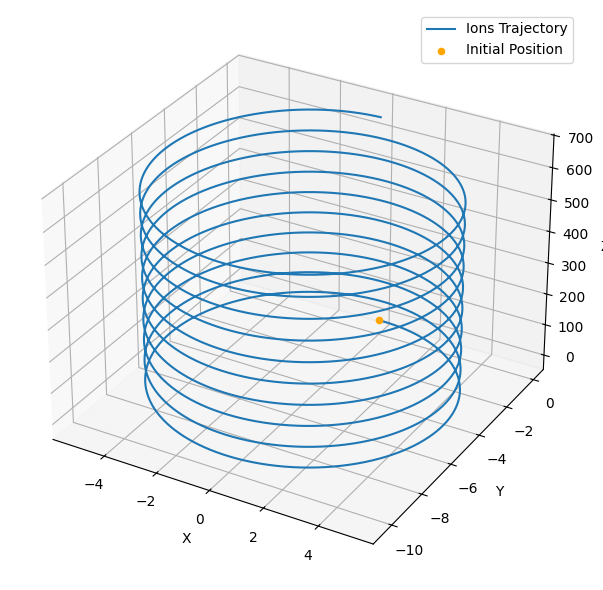

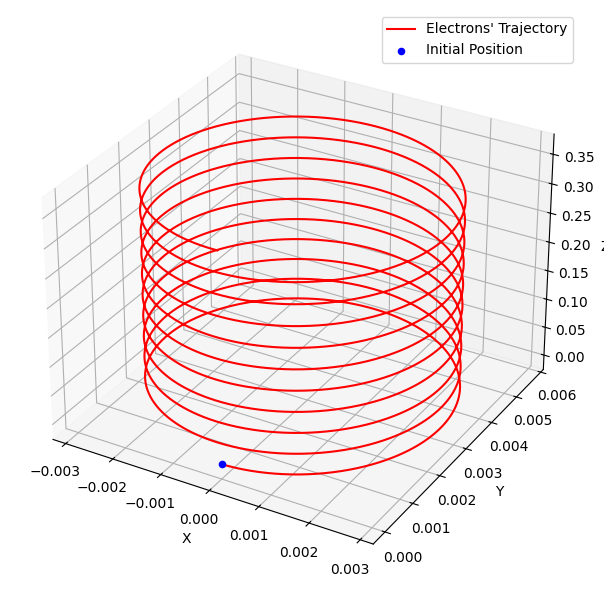

In [4]:
#Uniform B, E=0

E0 = np.array([0, 0, 0])
B0 = np.array([0, 0, 1])

# Initial conditions
x0 = np.array([0, 0, 0])
v0 = np.array([0.5, 0, 1])

x_e, v_e, times = time_setup(q_e, m_e, x0, v0, E=E0, B=B0)
x_i, v_i, times = time_setup(q_i, m_i, x0, v0, E=E0, B=B0)

# Ions' Plots
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_i[:,0]*1e9, x_i[:,1]*1e9, x_i[:,2]*1e9, label="Ions Trajectory")
ax.scatter(x_i[0,0]*1e9, x_i[0,1]*1e9, x_i[0,2]*1e9, color='orange', label='Initial Position')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()


#Electrons' Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_e[:,0]*1e9, x_e[:,1]*1e9, x_e[:,2]*1e9, color='red', label="Electrons' Trajectory")
ax.scatter(x_e[0,0]*1e9, x_e[0,1]*1e9, x_e[0,2]*1e9, color='blue', label='Initial Position')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()
plt.show()

# Uniform Magnetic Field and Electric Field

We have now $\vec{E} = E_x \hat{x} + E_z\hat{z}$, with the same procedure:
$$
m \frac{d\vec{v}}{dt} = q ( \vec{E} + \vec{v} \times \vec{B} )
$$

$$
m (\frac{dv_x}{dt}\hat{x} + \frac{dv_y}{dt} \hat{y} + \frac{dv_z}{dt}\hat{z} ) = q ( (E_x + Bv_y)\hat{x} - Bv_x \hat{y} + E_z \hat{z})
$$

\begin{align}
    \dot{v_x} = \frac{q}{m} (E_x + Bv_y) \rightarrow \ddot{v_x} = -(\frac{qB}{m})^2 \dot{v}_y = -\omega^2_C v_x \\
    \dot{v_y} = -\frac{q}{m} B v_x \rightarrow \ddot{v_y} = -(\frac{qB}{m})^2 \dot{v}_x = -\omega^2_C (\frac{E_x}{B} + v_y)  \\
    \dot{v_z} = \frac{q}{m} E_z \rightarrow v_z = \frac{q}{m} E_zt
\end{align}


The coupled equations for $v_x, v_y$ giving
\begin{align}
    v_x = v_\perp e^{i\omega_C t} \\
    v_y = \pm iv_\perp e^{i\omega_C t} - \frac{E_x}{B}
\end{align}

$$
(x-x_0)^2 + (y-y_0)^2 = \frac{v^2_\perp}{\omega_C^2} = r^2_L
$$

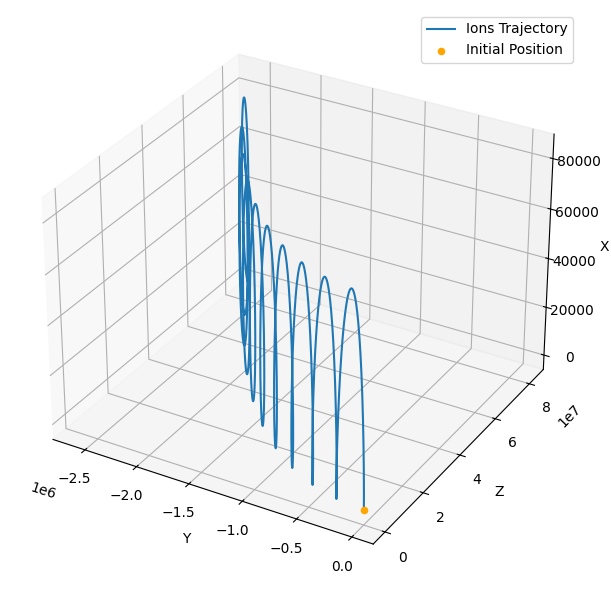

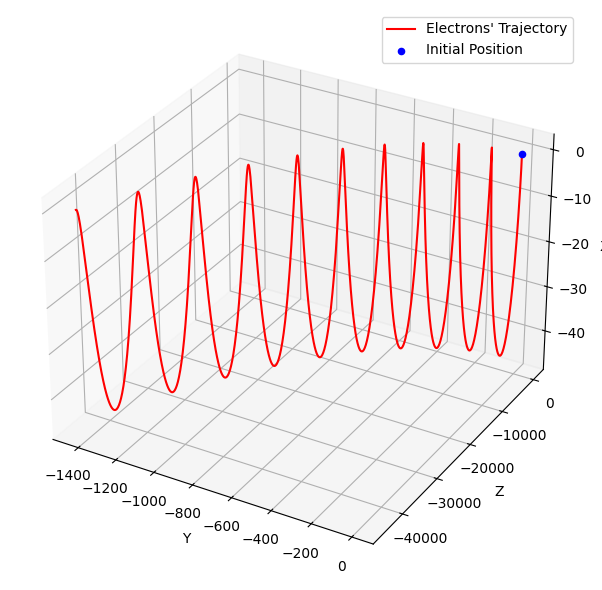

In [5]:
# Initial conditions
Uniform_E = np.array([1e5, 0, 1e5])
B = np.array([0, 0, 5])
v0 = np.array([0.5, 0.0, 1.0])
x0 = np.array([0.0, 0.0, 0.0])

x_e, v_e, times = time_setup(q_e, m_e, x0, v0, E=Uniform_E, B=B)
x_i, v_i, times = time_setup(q_i, m_i, x0, v0, E=Uniform_E, B=B)

# Plots
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_i[:,1]*1e9, x_i[:,2]*1e9, x_i[:,0]*1e9, label="Ions Trajectory")
ax.scatter(x_i[0,1]*1e9, x_i[0,2]*1e9, x_i[0,0]*1e9, color='orange', label='Initial Position')
ax.set_xlabel("Y")
ax.set_ylabel("Z")
ax.set_zlabel("X")
ax.legend()
plt.tight_layout()


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_e[:,1]*1e9, x_e[:,2]*1e9, x_e[:,0]*1e9, color='red', label="Electrons' Trajectory")
ax.scatter(x_e[0,1]*1e9, x_e[0,2]*1e9, x_e[0,0]*1e9, color='blue', label='Initial Position')
ax.set_xlabel("Y")
ax.set_ylabel("Z")
ax.set_zlabel("X")
ax.legend()
plt.tight_layout()
plt.show()

# $\nabla B \perp B$: Grad-B Drift

Let the change of magnitude of B depends on y value but magnetic field lines are along z-axis. For simplicity, we assume $E=0$.
$$
r_L = \frac{v_\perp}{\omega_C} = \frac{mv_\perp}{qB_z(y)}
$$

So at larger y, the radius of gyration becomes smaller.

By the same procedure:
$$
F_x = qv_yB_z(y), \quad F_y = -qv_xB_z(y), \quad F_z = 0
$$

For simplicity, we let the change in y is slow:
$$
B_z(y) = B_0 + y \frac{\partial B_z}{\partial y}
\begin{cases}
    F_x = qv_yB_0 + qv_y y \frac{\partial B_z}{\partial y} \\
    F_y = - qv_x B_0 - qv_x y \frac{\partial B_z}{\partial y}
\end{cases}
$$

When B was uniform:
\begin{align}
    v_x = v_\perp \cos (\omega_C t), \qquad v_y = \mp v_\perp \sin (\omega_C t) \\
    x = r_\perp \sin (\omega_C t), \qquad y = \pm r_\perp \cos (\omega_C t)
\end{align}

Hence:
$$
F_x = \mp q v_\perp B_0 \sin (\omega_C t) \mp qv_\perp r_\perp \sin(\omega_C t) \cos(\omega_C t) \frac{\partial B_z}{\partial y}
$$
$$
F_y = - q v_\perp B_0 \cos (\omega_C t) \mp qv_\perp r_\perp \cos^2(\omega_C t) \frac{\partial B_z}{\partial y}
$$

$$
\text{To average over cycle:} \\
\begin{cases}
    \langle \cos(\omega_C t) \rangle = 0 \\
     \langle \sin(\omega_C t) \rangle = 0 \\
      \langle \cos(\omega_C t)\sin(\omega_C t) \rangle = 0 \\
       \langle \cos^2(\omega_C t) \rangle = 1/2 \\
        \langle \sin^2(\omega_C t) \rangle = 1/2
\end{cases}
$$
Hence:
$$
\langle F_x \rangle = 0, \quad
\langle F_y \rangle = \mp \frac{qv_\perp r_\perp}{2} \frac{\partial B_z}{\partial y}
$$

$$
\vec{v}_{\nabla B} = \frac{1}{q} \frac{\vec{F} \times \vec{B}}{B^2} = \frac{\mp v_\perp r_\perp}{2B(y)} \frac{\partial B_z}{\partial y} \hat{x} = \pm  \frac{v_\perp r_\perp}{2B^2} (\vec{B} \times \nabla B)
$$

The sign again stands for the charge, the drift is in opposite directions for ions and electrons and causes a current transverse to B.

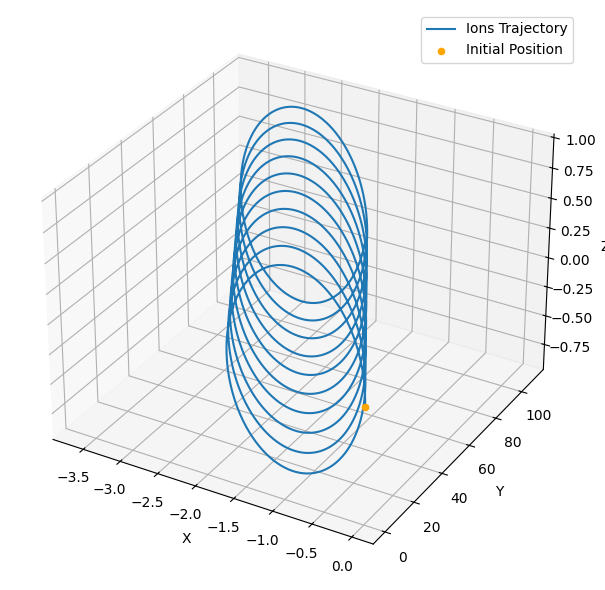

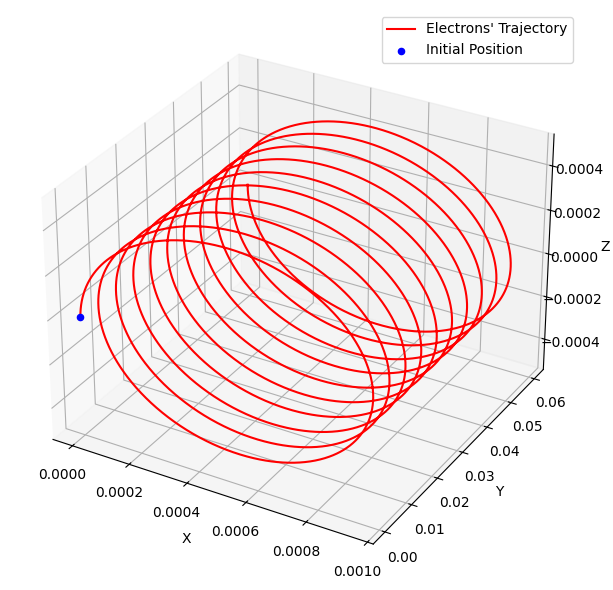

In [6]:
# Initial conditions
gradB = -0.5e9
B0 = 6
x0 = np.array([0, 0, 0])
v0 = np.array([0.5, 0, 1])

def Grad_B(pos, t=0):
    Bz = B0 + gradB * pos[0]
    return np.array([0, 0, Bz])

x_e, v_e, times = time_setup(q_e, m_e, x0, v0, E=E0, B_func=Grad_B)
x_i, v_i, times = time_setup(q_i, m_i, x0, v0, E=E0, B_func=Grad_B)

# Plots
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_i[:,1]*1e9, x_i[:,2]*1e9, x_i[:,0]*1e9, label="Ions Trajectory")
ax.scatter(x_i[0,0]*1e9, x_i[0,1]*1e9, x_i[0,2]*1e9, color='orange', label='Initial Position')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_e[:,1]*1e9, x_e[:,2]*1e9, x_e[:,0]*1e9, color='red', label="Electrons' Trajectory")
ax.scatter(x_e[0,0]*1e9, x_e[0,1]*1e9, x_e[0,2]*1e9, color='blue', label='Initial Position')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()
plt.show()

# Curved B: Curvature Drift

For the magnetic field in a toroid, the lines are curved.
There are two kind of forces acting on a particle moving in a circular path: centrifugal force (outwards), and centripetal force (inwards). We have the parallel component of velocity along $F_{cf}$.
$$
\vec{F}_{cf} = \frac{mv^2_\parallel}{R_0} \hat{R}_0 =  \frac{mv^2_\parallel}{R^2_0} \vec{R}_0
$$

$$
\vec{v}_R = \frac{1}{q} \frac{\vec{F} \times \vec{B}}{B^2} = \frac{mv^2_\parallel}{R^2_0} \vec{R}_0 \times \vec{B}
$$
This the drift due to the curved path.

We calculated before the drift due to the gradient of B as a result of changing $R_0$ (the radius between the magnetic field lines and the center of toroid), so we will use it assuming a uniform current flowing through the toroid, using Biot-Savart law we know $\vec{B} \propto \frac{1}{R_0} \hat{R_0}$, So:
$$
\nabla B = \frac{-1}{R_0^2} \hat{R}_0 = \frac{-1}{R_0^3} \vec{R}_0
$$

Hence:
$$
\vec{v}_{\nabla B} = \frac{v_\perp r_\perp}{2B^2} (\vec{B} \times \nabla B) = \frac{v_\perp r_\perp}{2B^2 R_0^3} (\vec{R}_0 \times \vec{B})
$$

The total drift:

$$
\vec{v}_R + \vec{v}_{\nabla B} = \left[ \frac{m v^2_\parallel}{q} + \frac{v_\perp r_\perp}{2R_0} \right] \frac{\vec{R}_0 \times \vec{B}}{B_0^2 R^2_0}
$$

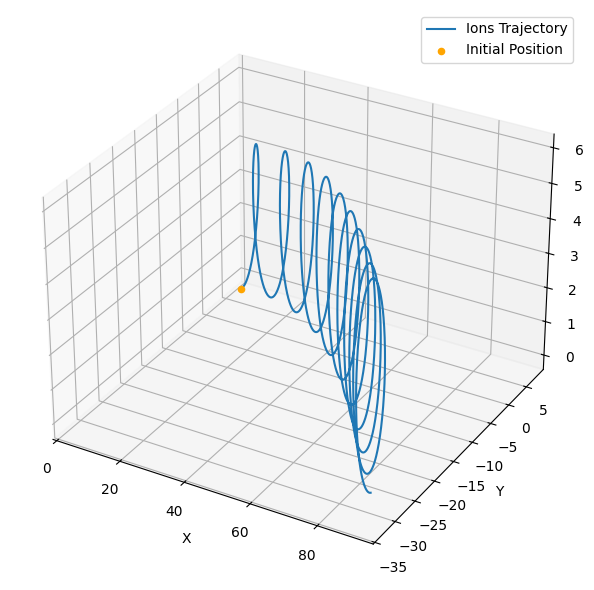

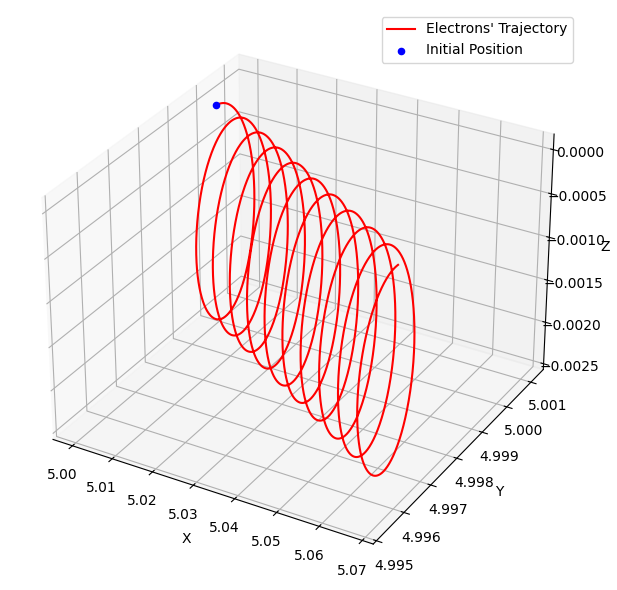

In [7]:
# Curved-B (Toroidal)
def Curved_B(pos, t=0):
    x = pos[0]
    y = pos[1]
    Xc = x
    Yc = y - R_curvature
    theta = np.arctan2(Yc, Xc)
    Bx = np.sin(theta) * B0
    By = np.cos(theta) * B0
    return np.array([Bx, By, 0.0])

# Initial conditions
v0 = np.array([0.01, 0.01, 0.0])
x0 = np.array([5e-9, 5e-9, 0.0])
R_curvature = 100e-9
B0 = 0.05

x_e, v_e, times = time_setup(q_e, m_e, x0, v0, E=E0, B_func=Curved_B)
x_i, v_i, times = time_setup(q_i, m_i, x0, v0, E=E0, B_func=Curved_B)

# Plots
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_i[:,0]*1e9, x_i[:,1]*1e9, x_i[:,2]*1e9, label="Ions Trajectory")
ax.scatter(x_i[0,0]*1e9, x_i[0,1]*1e9, x_i[0,2]*1e9, color='orange', label='Initial Position')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_e[:,0]*1e9, x_e[:,1]*1e9, x_e[:,2]*1e9, color='red', label="Electrons' Trajectory") # Corrected indexing to x, y, z
ax.scatter(x_e[0,0]*1e9, x_e[0,1]*1e9, x_e[0,2]*1e9, color='blue', label='Initial Position')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()
plt.show()

# $\nabla B \parallel B$: Magnetic Mirrors


This time to confine plasma, the change of magnitude of B depends on the actual direction of B, if $\vec{B} = B\hat{z}$ then it changes parallel to z-axis. Let $B_\theta = 0$, considering a magnetic field pointing in a z-direction and magnitude varies along it.

$$
\nabla \cdot \vec{B} = \frac{1}{r} \frac{\partial}{\partial r} (rB_r) + \frac{\partial B_z}{\partial z} = 0
$$
Integrating with respect to r:
$$
B_r = \frac{-r}{2} \frac{\partial B_z}{\partial z}
$$

Using Lorentz force formula again:
$$
\vec{F} = q ( v_\theta B_z \hat{r} + (v_z B_r - v_r B_z) \hat{\theta} + v_\theta B_r \hat{z} )
$$
$$
\vec{F}= q ( v_\theta B_z \hat{r} - (\frac{rv_z}{2} \frac{\partial B_z}{\partial z} + v_r B_z) \hat{\theta} + \frac{rv_\theta}{2} \frac{\partial B_z}{\partial z}  \hat{z} )
$$

Considering $v_\theta = v_\perp$, $r_\perp = v_\perp/\omega_C$
$$
\vec{F}= q ( v_\perp B_z \hat{r} - (\frac{v_\perp v_z}{2\omega_C} \frac{\partial B_z}{\partial z} + v_r B_z) \hat{\theta} + \frac{v^2_\perp}{2\omega_C} \frac{\partial B_z}{\partial z}  \hat{z} )
$$

$$
F_z = \mp q\frac{v^2_\perp}{2\omega_C} \frac{\partial B_z}{\partial z}  = \frac{-qv^2_\perp m}{2qB} \frac{\partial B_z}{\partial z} = \frac{-v^2_\perp m}{2B} \frac{\partial B_z}{\partial z} = -\mu \frac{\partial B_z}{\partial z}
$$

We have $\mu$, which is the magnetic moment of gyrating particle.

Since the magnetic moment is constant, we know that the confinement is not perfect and some particles may escape.
$$
\mu = \frac{mv^2_\perp}{2B} = \text{constant}, \qquad v_\perp = v \sin\theta
$$
$$
\frac{\sin^2 \theta}{B} = \text{constant}, \rightarrow \frac{\sin^2 \theta}{B} = \frac{\sin^2 \theta_0}{B_0} \rightarrow \frac{\sin^2 \theta}{\sin^2 \theta_0} = \frac{B}{B_0}
$$

If the pitch angle $\theta < 90$, the particle escapes, and if $\theta > 90$, the particle reflects again through the strong and weak magnetic fields.


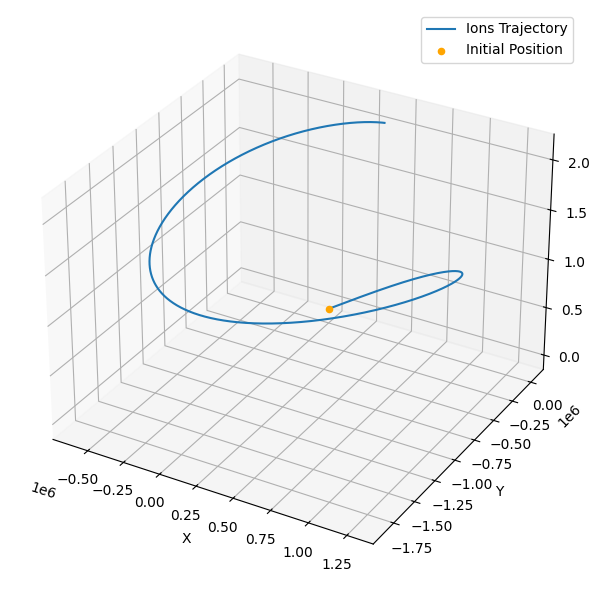

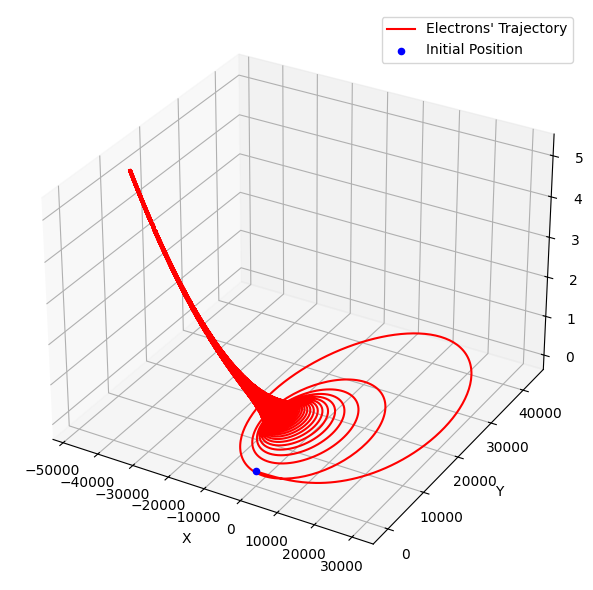

In [8]:
def B_mirror(pos, t=0):
    z = pos[2]
    alpha = 10e4
    Bz = B0 * alpha * z
    x = pos[0]
    y = pos[1]
    r = np.linalg.norm([x, y])
    Br = -r/2  * alpha * B0

    return np.array([Br, 0, Bz])

# Initial conditions
x0 = np.array([0.0, 0, 0.0])
v0 = np.array([5e5, 0, 5e5])

x_e, v_e, times = time_setup(q_e, m_e, x0, v0, E=E0, B_func=B_mirror)
x_i, v_i, times = time_setup(q_i, m_i, x0, v0, E=E0, B_func=B_mirror)

# Plots
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(x_i[:,0]*1e9, x_i[:,1]*1e9, x_i[:,2]*1e9, label="Ions Trajectory")
ax.scatter(x_i[0,0]*1e9, x_i[0,1]*1e9, x_i[0,2]*1e9, color='orange', label='Initial Position')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_e[:,0]*1e9, x_e[:,1]*1e9, x_e[:,2]*1e9, color='red', label="Electrons' Trajectory")
ax.scatter(x_e[0,0]*1e9, x_e[0,1]*1e9, x_e[0,2]*1e9, color='blue', label='Initial Position')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()
plt.show()

# Nonuniform E Field

Assuming $\vec{E} = E_0 \cos(kx) \hat{x}$, with the same procedure:

$$
\dot{v}_x = \frac{qB}{m} v_y + \frac{q}{m} E_x(x) \qquad \rightarrow \ddot{v}_x = -\omega_C^2 v_x \pm \omega_C \frac{\dot{E_x}}{B}
$$
$$
\dot{v}_y = -\frac{qB}{m} v_x \qquad \rightarrow \ddot{v}_y = -\omega_C^2 v_y - \omega^2_C \frac{E_x}{B}
$$

From uniform case: $x=x_0 + r_L \sin(\omega_C t)$

$$
\vec{E} = E_0 \cos(kx) \hat{x} = E_0 \cos(kx_0 + kr_L \sin(\omega_C t)) \hat{x}
$$
$$
\vec{E} = E_0 ( \cos(kx_0)\cos(kr_L \sin(\omega_C t)) - \sin(kx_0)\sin(kr_L \sin(\omega_C t))\hat{x}
$$
$$
    \text{Taylor Series:}
\begin{cases}
    \cos(\epsilon) = 1 - \frac{\epsilon^2}{2} + ... \\
    \sin(\epsilon) = \epsilon - ...
\end{cases}
$$

$$
\vec{E} = E_0 ( \cos(kx_0)(1- \frac{k^2 r^2_L}{2} \sin^2(\omega_C t)) - \sin(kx_0)(kr_L \sin(\omega_C t)) \hat{x}
$$
$$
\dot{\vec{E}}  = kE_0 r_L \omega_C \sin(kx) \cos(\omega_C t) = kr_L \omega_C \sin(kx) \vec{E}(x)
$$

Averaging over the cycle:
$$
\langle \cos(kx) \rangle \approx \cos(kx_0) - \frac{k^2 r^2_L}{4} \cos(kx_0)
$$

\begin{align}
    \langle \ddot{v}_x\rangle = 0 \qquad \rightarrow \langle v_x \rangle = 0 \\
    \langle \ddot{v}_y\rangle = 0 \qquad \rightarrow \langle v_y \rangle = \frac{-\omega_c E_0 \cos(kx_0)}{B} (1-\frac{k^2 r_L^2}{4}) = \frac{-E_x(x_0)}{B}(1-\frac{k^2 r_L^2}{4})
\end{align}

$\rightarrow \textbf{Note:} $

For $E=E_0 e^{i(kx+\omega t)}$, We have: $\frac{\partial^2 E}{\partial x^2} = -k^2 E_0 e^{i(kx+\omega t)} = -k^2 E$, so we can substitute $\nabla^2 = -k^2$.

$$
\vec{v}_E = (1+\frac{r^2_L\nabla^2}{4}) \frac{\vec{E} \times \vec{B}}{B^2}
$$

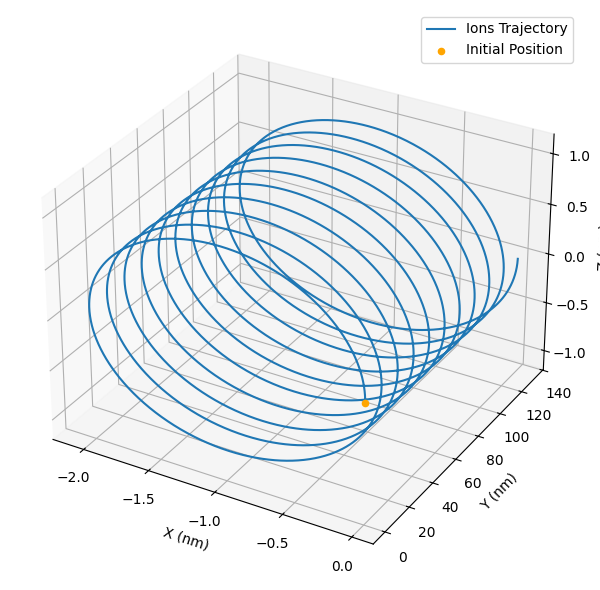

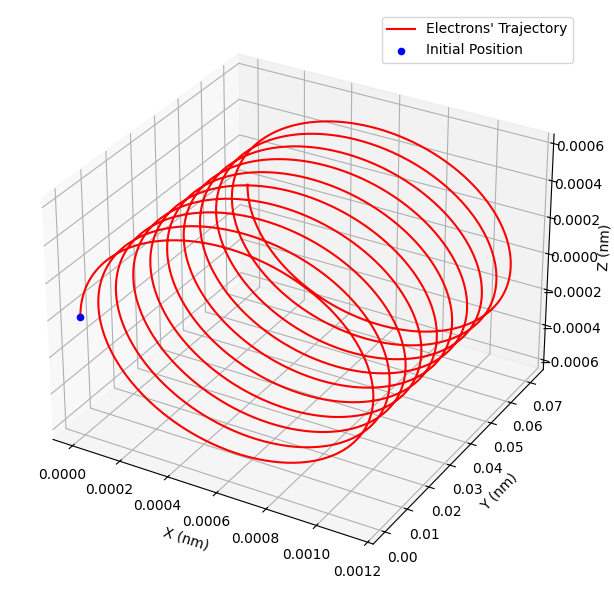

In [9]:
def nonuniform_E(pos, E0=1e5, k=1e7):
    x = pos[0]
    Ex = E0 * np.cos(k * x)
    return np.array([Ex, 0.0, 0.0])

# Initial conditions
B=np.array([0,0,5])
x0 = np.array([0, 0, 0])
v0 = np.array([0.5, 0, 1])

x_e, v_e, times = time_setup(q_e, m_e, x0, v0, E_func=nonuniform_E, B=B)
x_i, v_i, times = time_setup(q_i, m_i, x0, v0, E_func=nonuniform_E, B=B)

# Plots
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_i[:,1]*1e9, x_i[:,2]*1e9, x_i[:,0]*1e9, label="Ions Trajectory")
ax.scatter(x_i[0,0]*1e9, x_i[0,1]*1e9, x_i[0,2]*1e9, color='orange', label='Initial Position')
ax.set_xlabel("X (nm)")
ax.set_ylabel("Y (nm)")
ax.set_zlabel("Z (nm)")
ax.legend()
plt.tight_layout()


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_e[:,1]*1e9, x_e[:,2]*1e9, x_e[:,0]*1e9, color='red', label="Electrons' Trajectory")
ax.scatter(x_e[0,0]*1e9, x_e[0,1]*1e9, x_e[0,2]*1e9, color='blue', label='Initial Position')
ax.set_xlabel("X (nm)")
ax.set_ylabel("Y (nm)")
ax.set_zlabel("Z (nm)")
ax.legend()
plt.tight_layout()
plt.show()

# Time-Varying B Field


We now consider the case where the magnetic field varies with time. The Lorentz force,
$$
\vec{F} = q(\vec{E} + \vec{v} \times \vec{B}),
$$

If $\vec{B}$ changes with time, it induces an electric field according to Faraday's law:
$$
\nabla \times \vec{E} = -\frac{d\vec{B}}{dt}
$$
and this induced electric field can do work on the particle.

Assuming the electric field is not uniform, we define the transverse velocity $\vec{v}_\perp = \frac{d\vec{l}}{dt}$, where $\vec{l}$ is the path length along the Larmor orbit. Taking the dot product of the equation of motion with $\vec{v}_\perp$ gives:
$$
\frac{d}{dt} \left( \frac{1}{2}mv_\perp^2 \right) = q \vec{E} \cdot \vec{v}_\perp = q \vec{E} \cdot \frac{d\vec{l}}{dt}
$$
Integrating over one gyroperiod $T = \frac{2\pi}{\omega_c}$:
$$
\delta\left( \frac{1}{2}mv_\perp^2 \right) = \int_0^T  \vec{E} \cdot \frac{d\vec{l}}{dt} dt = q \oint  \vec{E} \cdot d\vec{l}
$$
By Stokes' theorem:
$$
\oint \vec{E} \cdot d\vec{l} = \int_S (\nabla \times \vec{E}) \cdot d{\vec{S}} = -\int_S \frac{d\vec{B}}{dt} \cdot d{\vec{S}}
$$
So the change in transverse energy becomes:
$$
\delta\left( \frac{1}{2}mv_\perp^2 \right) = -q \int_S \frac{d\vec{B}}{dt} \cdot d{\vec{S}}
$$

Let $S = \pi r_L^2$ be the area enclosed by the Larmor orbit. Then:
$$
\delta\left( \frac{1}{2}mv_\perp^2 \right) = -q \pi r_L^2 \frac{d\vec{B}}{dt}
$$
Using $r_L = \frac{mv_\perp}{qB}$:
$$
\delta\left( \frac{1}{2}mv_\perp^2 \right) = \frac{\pi m v_\perp^2}{B \omega_C} \frac{d\vec{B}}{dt}
$$

Now recall the definition of magnetic moment:
$$
\mu = \frac{1}{2} \frac{mv_\perp^2}{B},
$$
then:
$$
\delta\left( \frac{1}{2}mv_\perp^2 \right) = \mu \delta B
$$
which implies:
$$
\delta(\mu B) = 0 \quad \Rightarrow \quad \delta \mu = 0.
$$

This means that the magnetic moment $\mu$ is invariant in a slowly varying magnetic field. As $B$ increases or decreases, the transverse energy and the Larmor radius adjust such that $\mu$ remains constant.


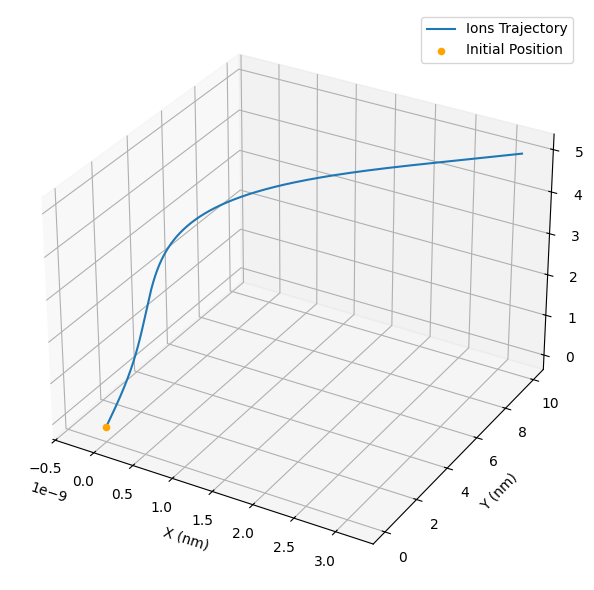

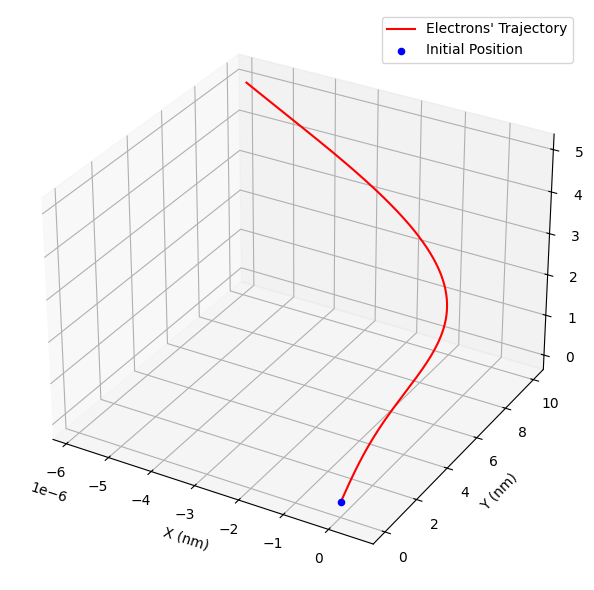

In [10]:
def time_B(time, B0=0.5, omega=1e9):

    t_scalar = float(time) if np.isscalar(time) else float(time[0])
    Bz = B0 * np.cos(omega * t_scalar)

    return np.array([0.0, 0.0, Bz])


# Initial conditions
E0 = np.array([0, 0, 0])

x0 = np.array([0, 0, 0])
v0 = np.array([0.5, 0, 1])

x_e, v_e, times = time_setup(q_e, m_e, x0, v0, E=E0, B_func=time_B)
x_i, v_i, times = time_setup(q_i, m_i, x0, v0, E=E0, B_func=time_B)

# Plots
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_i[:,1]*1e9, x_i[:,2]*1e9, x_i[:,0]*1e9, label="Ions Trajectory")
ax.scatter(x_i[0,0]*1e9, x_i[0,1]*1e9, x_i[0,2]*1e9, color='orange', label='Initial Position')
ax.set_xlabel("X (nm)")
ax.set_ylabel("Y (nm)")
ax.set_zlabel("Z (nm)")
ax.legend()
plt.tight_layout()


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_e[:,1]*1e9, x_e[:,2]*1e9, x_e[:,0]*1e9, color='red', label="Electrons' Trajectory")
ax.scatter(x_e[0,0]*1e9, x_e[0,1]*1e9, x_e[0,2]*1e9, color='blue', label='Initial Position')
ax.set_xlabel("X (nm)")
ax.set_ylabel("Y (nm)")
ax.set_zlabel("Z (nm)")
ax.legend()
plt.tight_layout()
plt.show()